# Semantic Segmentation Using U-Net

In this Project, We will design and train a U-Net. This type of networks are used for semantic segmentation. This task is segmenting the image, semantically to different parts. We can consider this as a classification, done on each pixel of the image! Below, We can see an example of the task:


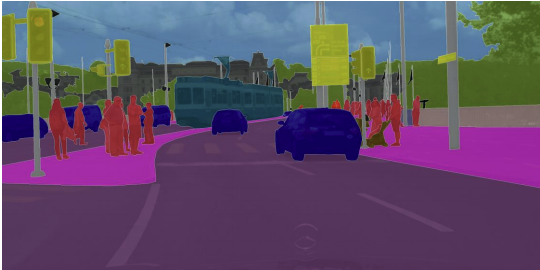 <br>
Example of a segmented image <br>


We will use a dataset which is used for "Self-Driving Car" Purposes. Understanding each pixel (in the view point of car) is an important task for self-driving cars. Let's proceed with this task to the end of this excercise!

## Downloading Dataset

In [1]:
%pip install --upgrade --no-cache-dir gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
!kaggle datasets download -d mojtabanafez/self-driving-car-dataset-ai-course

Dataset URL: https://www.kaggle.com/datasets/mojtabanafez/self-driving-car-dataset-ai-course
License(s): apache-2.0
 99%|████████████████████████████████████████▍| 513M/519M [00:04<00:00, 128MB/s]
100%|█████████████████████████████████████████| 519M/519M [00:04<00:00, 111MB/s]


In [4]:
!mv /kaggle/working/self-driving-car-dataset-ai-course.zip /kaggle/working/Files.zip

mv: cannot stat '/kaggle/working/self-driving-car-dataset-ai-course.zip': No such file or directory


In [4]:
# !gdown --id 11r4jZIlLMaX8b36lESUpPRiQi_GIcOA3

In [5]:
!unzip Files.zip > out.txt

In [6]:
%pip install --upgrade torch torchvision torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━

<a name='1'></a>
## 1 - libraries

Let's import libraries and set our device

In [8]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

### Set torch device to appropriate type for GPU training

In [10]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
)
device

device(type='cuda')

<a name='2'></a>
## 2 - Load the Data

In [16]:
path = "" # Path to the root folder
image_path = os.path.join(path, "Files/data/CameraRGB/")
mask_path = os.path.join(path, "Files/data/CameraMask/")
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Visualize the some of the unmasked and masked images from the dataset:

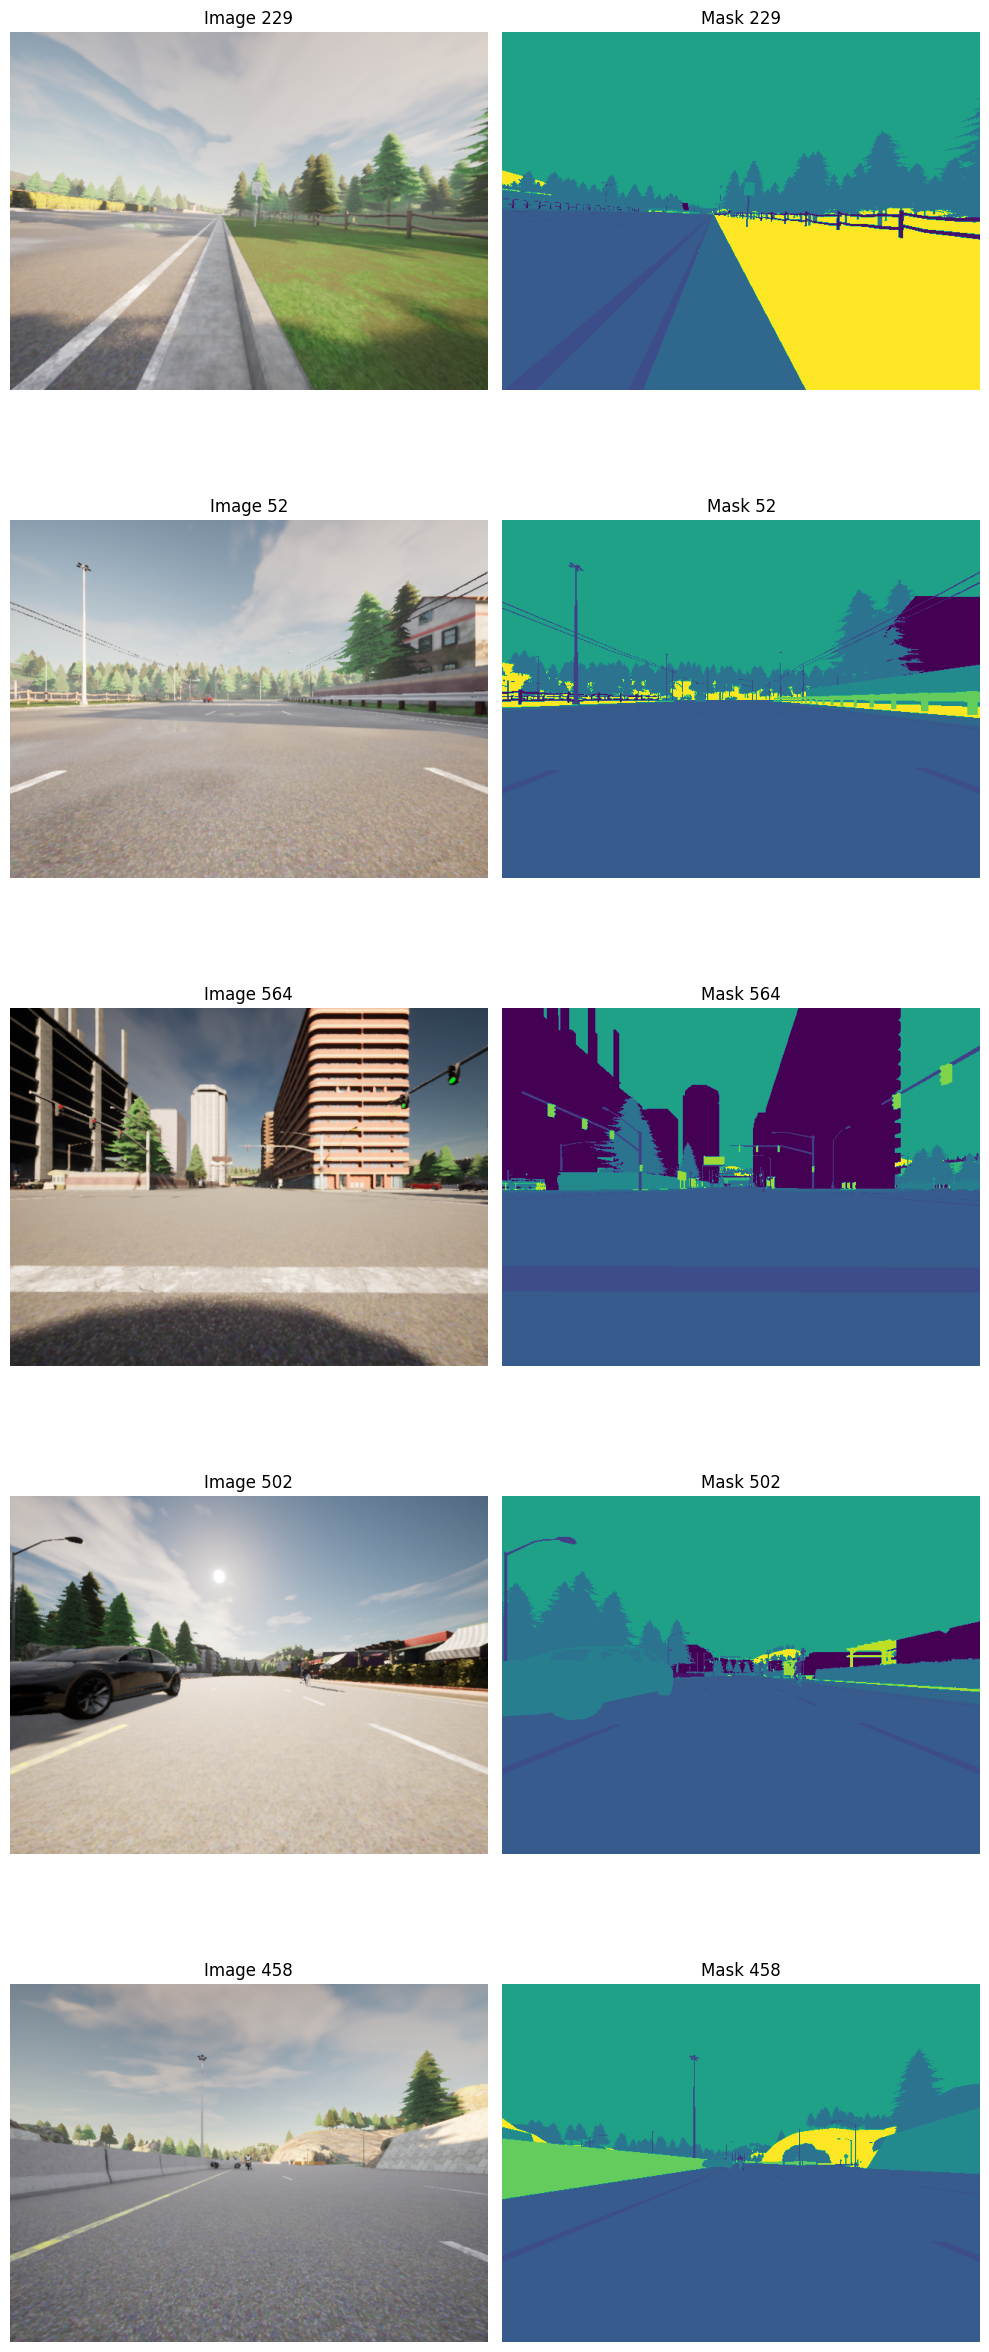

In [37]:
N = 5
import random
random.seed(42)
random_indices = random.sample(range(len(image_list)), N)

fig, axes = plt.subplots(N, 2, figsize=(10, 5 * N))

for i, idx in enumerate(random_indices):
    img = plt.imread(image_list[idx])
    mask = plt.imread(mask_list[idx])

    # Display the image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image {idx + 1}")
    axes[i, 0].axis('off')

    # Display the mask
    axes[i, 1].imshow(mask[:, :, 0])
    axes[i, 1].set_title(f"Mask {idx + 1}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

<a name='2-2'></a>
### 2.2 - Preprocess Data



In [38]:
class Segmentation_Dataset(Dataset):
    def __init__(self, ImagesDirectory, MasksDirectory):
        super(Segmentation_Dataset, self).__init__()

        self.image_files = ImagesDirectory
        self.mask_files = MasksDirectory
        
        self.images = []
        self.masks = []
        for i in range(len(self.image_files)):
            image_path = os.path.join(self.image_files[i])
            mask_path = os.path.join(self.mask_files[i])

            self.images.append(Image.open(image_path))
            self.masks.append(Image.open(mask_path))
            
        self.mask_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.PILToTensor(),
                transforms.Lambda(lambda x : x[0])
            ]
        )
        
        self.image_transforms = transforms.Compose(
            [
                transforms.Resize((192, 256)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x : x[:3]),
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        
        image = self.images[index]
        mask = self.masks[index]

        image = self.image_transforms(image)
        mask = self.mask_transforms(mask)

        return image, mask


In [39]:
def plot_item(image, mask):
    image_np = image.cpu().numpy().transpose((1,2,0))
    mask_np = mask.cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(mask_np)
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.show()

<a name='2-3'></a>
### 2.3 - Hyper-parameters and Optimizer

In [40]:
EPOCHS = 50
BATCH_SIZE = 16
LR = 0.001
B1 = 0.9
B2 = 0.999

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.


<a name='3-1'></a>
### 3.1 - Model Details

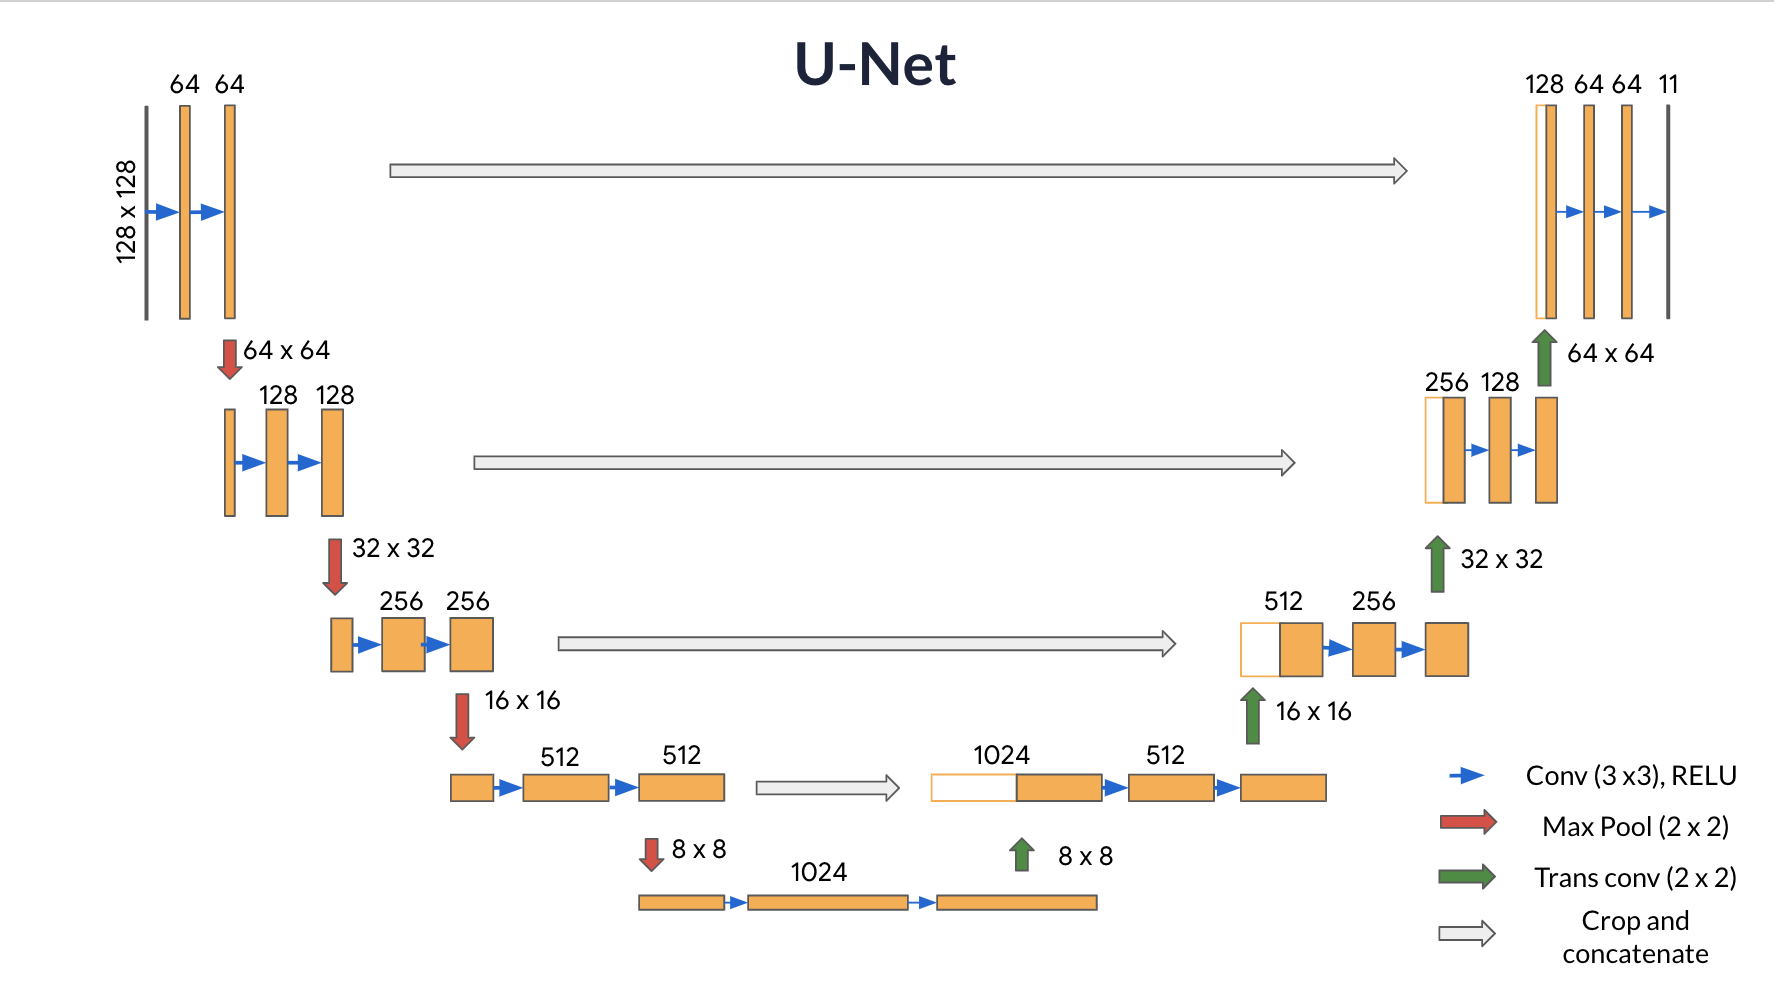<br>
U-Net Architecture<br>



<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

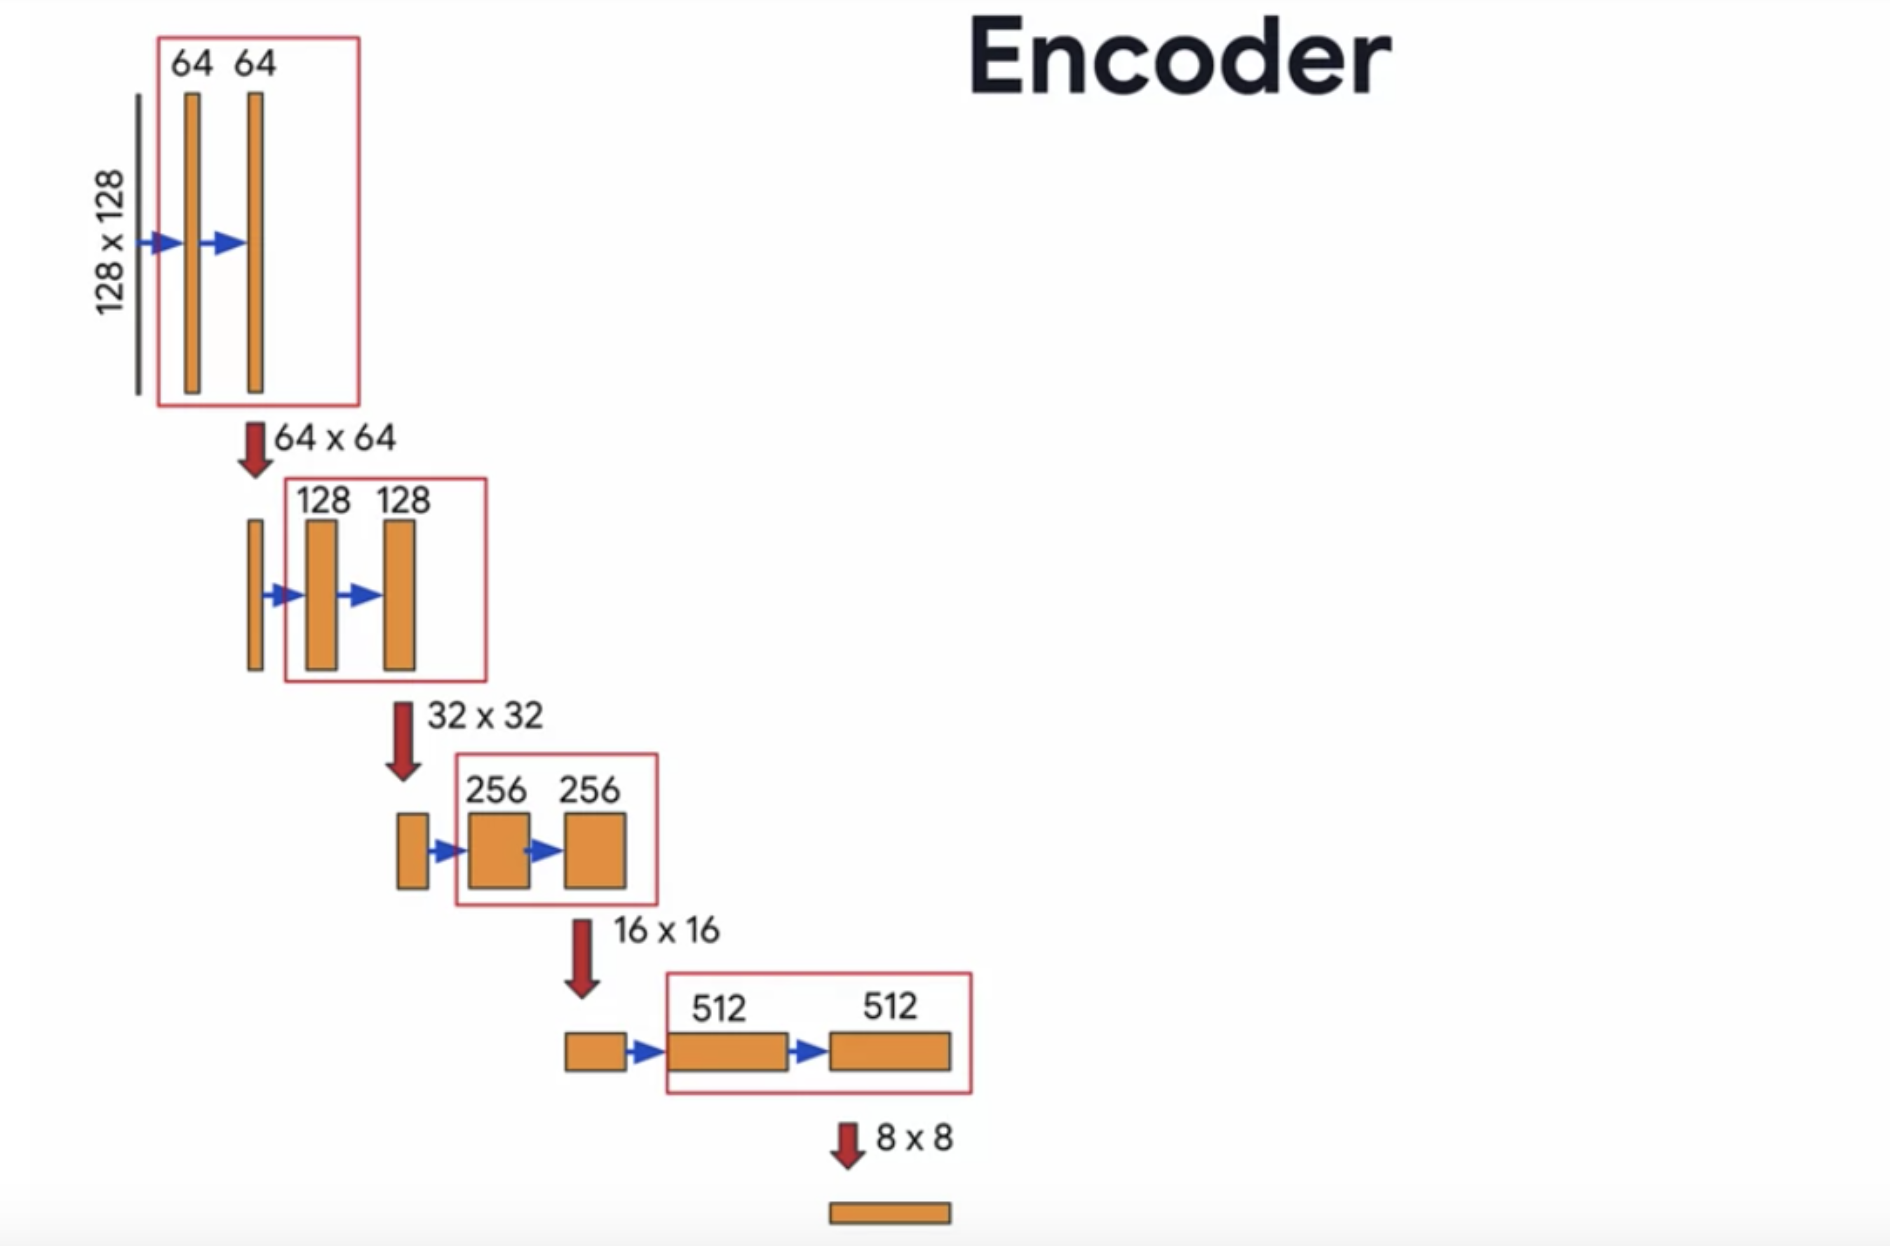<br>
The U-Net Encoder up close <br>


In [41]:
class conv_block(nn.Module):
    def __init__(self, in_ch, n_filters=32, dropout_prob=0, max_pooling=True):
        """
        Convolutional downsampling block

        Arguments:
            in_ch -- Number of channels of input tensor
            n_filters -- Number of filters for the convolutional layers
            dropout_prob -- Dropout probability
            max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        """
        super().__init__()

        self.max_pooling = max_pooling
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
        )
        self.pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        Convolutional downsampling forward

        Arguments:
            x -- Input data/batch
        Returns:
            next_layer, skip_connection --  Next layer and skip connection outputs
        """
        skip_connection = self.convs(x)
        next_layer = self.pooling_layer(skip_connection) if self.max_pooling else skip_connection

        return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

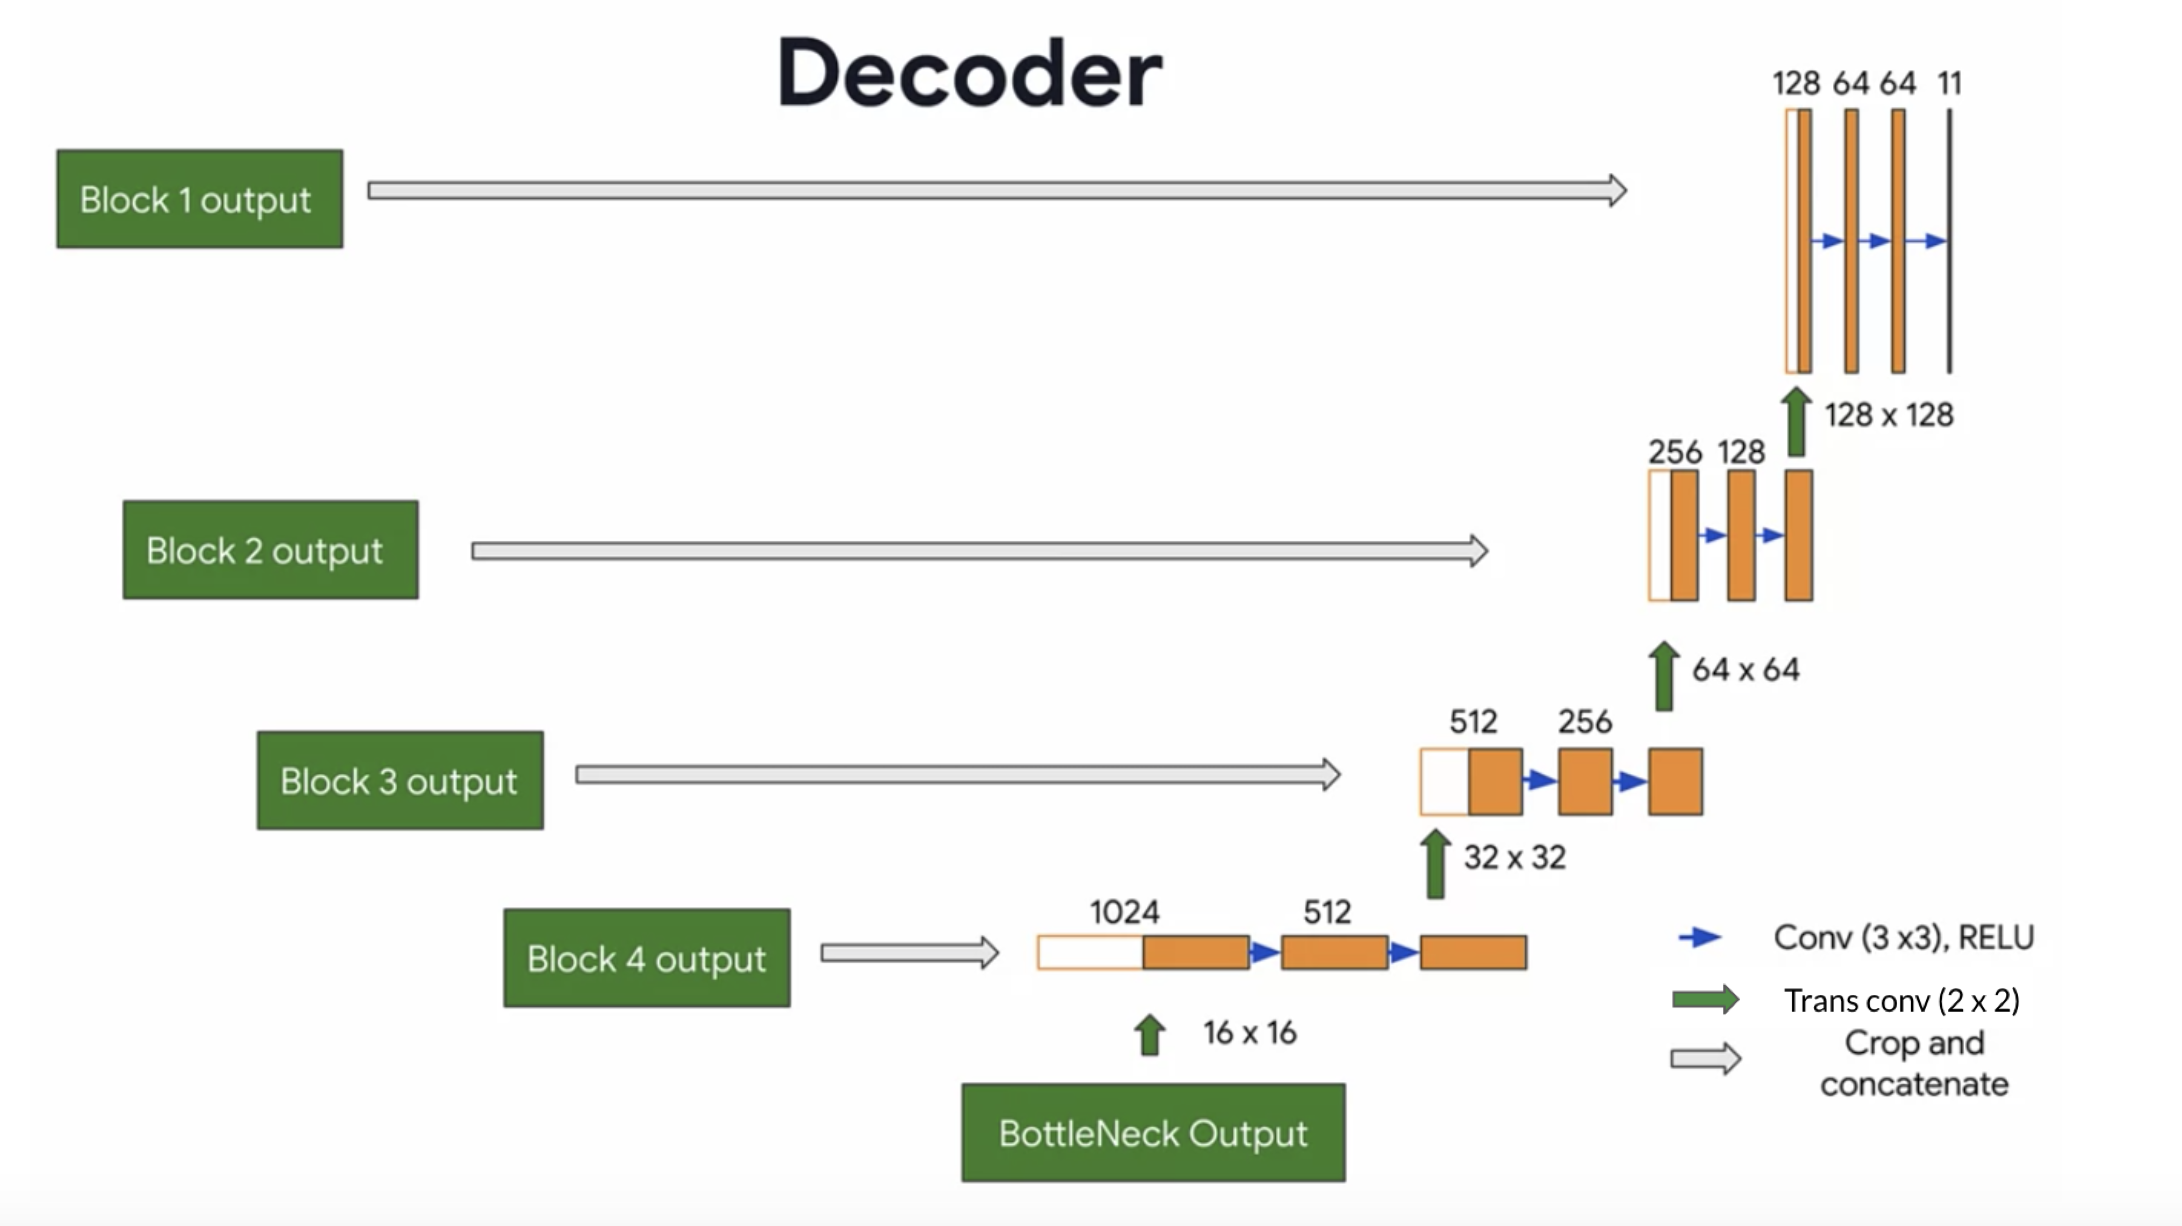<br>
The U-Net Decoder up close <br>




In [43]:
class upsampling_block(nn.Module):
    def __init__(self, in_ch, skip_ch, n_filters=32):
        """
        Convolutional upsampling block

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            skip_ch -- Number of channels of input tensor from previous skip layer
            n_filters -- Number of filters for the convolutional layers
        """
        super().__init__()
        
        self.up_conv = nn.ConvTranspose2d(in_ch, n_filters, kernel_size=2, stride = 2)
        self.convs = nn.Sequential(
            nn.Conv2d(n_filters + skip_ch, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU(inplace=True),
        )

    def forward(self, expansive_input, contractive_input):
        """
        Convolutional upsampling forward

        Arguments:
            expansive_input -- Data from bottleneck or previous upsampling_block
            contractive_input -- Data from corresponding layer in the encoder
        Returns:
            conv -- Tensor output
        """
        up_conved = self.up_conv(expansive_input)
        cat_inputs = torch.cat((contractive_input, up_conved), dim = 1)
        conv = self.convs(cat_inputs)

        return conv
    

<a name='3-4'></a>
### 3.4 - Build the Model

This is where we'll put it all together, by chaining the encoder, bottleneck, and decoder! we'll need to specify the number of output channels, which for this particular set would be 23. **That's because there are 23 possible labels for each pixel in this self-driving car dataset.**

In [44]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, n_filters=32, n_classes=23):
        """
        UNet

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            n_filters -- Number of filters for the convolutional layers
            n_classes -- Number of diffrent segments
        """
        super().__init__()
        
        # Down-sampling
        self.encoder1 = conv_block(in_ch = in_ch, n_filters = n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder2 = conv_block(in_ch = n_filters, n_filters = 2 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder3 = conv_block(in_ch = 2 * n_filters, n_filters = 4 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder4 = conv_block(in_ch = 4 * n_filters, n_filters = 8 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder5 = conv_block(in_ch = 8 * n_filters, n_filters = 16 * n_filters, dropout_prob = 0, max_pooling=False)
            
        # Up-sampling and final layer
        self.decoder4 = upsampling_block(in_ch = 16 * n_filters, skip_ch = 8 * n_filters, n_filters = 8 * n_filters)
        self.decoder3 = upsampling_block(in_ch = 8 * n_filters, skip_ch = 4 * n_filters, n_filters = 4 * n_filters)
        self.decoder2 = upsampling_block(in_ch = 4 * n_filters, skip_ch = 2 * n_filters, n_filters = 2 * n_filters)
        self.decoder1 = upsampling_block(in_ch = 2 * n_filters, skip_ch = n_filters, n_filters = n_filters)
        
        self.final_layer = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        """
        UNet forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        next_layer1, skip_connection1 = self.encoder1(x)
        next_layer2, skip_connection2 = self.encoder2(next_layer1)
        next_layer3, skip_connection3 = self.encoder3(next_layer2)
        next_layer4, skip_connection4 = self.encoder4(next_layer3)
        next_layer5, _ = self.encoder5(next_layer4)
        
        next_layer6 = self.decoder4(next_layer5, skip_connection4)
        next_layer7 = self.decoder3(next_layer6, skip_connection3)
        next_layer8 = self.decoder2(next_layer7, skip_connection2)
        next_layer9 = self.decoder1(next_layer8, skip_connection1)
        
        out = self.final_layer(next_layer9)

        return out

### Check out the model summary

In [45]:
unet = UNet().to(device)
summary(unet, (3, 192, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 256]             896
       BatchNorm2d-2         [-1, 32, 192, 256]              64
              ReLU-3         [-1, 32, 192, 256]               0
            Conv2d-4         [-1, 32, 192, 256]           9,248
       BatchNorm2d-5         [-1, 32, 192, 256]              64
              ReLU-6         [-1, 32, 192, 256]               0
           Dropout-7         [-1, 32, 192, 256]               0
         MaxPool2d-8          [-1, 32, 96, 128]               0
        conv_block-9  [[-1, 32, 96, 128], [-1, 32, 192, 256]]               0
           Conv2d-10          [-1, 64, 96, 128]          18,496
      BatchNorm2d-11          [-1, 64, 96, 128]             128
             ReLU-12          [-1, 64, 96, 128]               0
           Conv2d-13          [-1, 64, 96, 128]          36,928
      BatchNorm2d-14     

<a name='3-6'></a>
### 3.6 - Dataset Loader For training and test

Below, We define a function that allows us to display both an input image, and its ground truth: the true mask. The true mask is what our trained model output is aiming to get as close to as possible.

In [46]:
from sklearn.model_selection import train_test_split

train_image, test_image, train_mask, test_mask = train_test_split(image_list, mask_list, test_size=0.2, random_state=42)

train_dataset = Segmentation_Dataset(train_image, train_mask)
test_dataset = Segmentation_Dataset(test_image, test_mask)

train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE)

<Figure size 1500x1500 with 0 Axes>

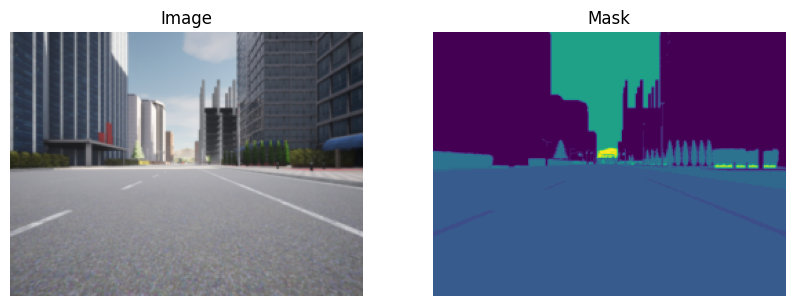

In [47]:
batch_image, batch_mask = next(iter(train_dataloader))

plt.figure(figsize=(15,15))
image = batch_image[0]
mask = batch_mask[0]

plot_item(image, mask)

<a name='3-7'></a>
### 3.7 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability.

In [48]:
criterion=nn.CrossEntropyLoss()

In [49]:
optimizer=torch.optim.Adam(unet.parameters(), 
                           lr = LR, 
                           betas = (B1, B2))

<a name='4'></a>
## 4 - Train the Model

In [50]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []

    for i, batch in enumerate(train_dataloader):
        image1, mask1 = batch
        image1 = image1.to(device)
        mask1 = mask1.to(device)

        optimizer.zero_grad()  
        outputs = unet(image1)  
                        
        loss = criterion(outputs, mask1.long())  
        loss.backward()  
        optimizer.step()  
        
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    print(f"EPOCH#{epoch},\t Loss:{mean_loss}")
    losses.append(mean_loss)

EPOCH#0,	 Loss:1.8506297570354533
EPOCH#1,	 Loss:0.9113662906412808
EPOCH#2,	 Loss:0.5982581050890796
EPOCH#3,	 Loss:0.4803575041159144
EPOCH#4,	 Loss:0.416547381652976
EPOCH#5,	 Loss:0.37317472921227507
EPOCH#6,	 Loss:0.35032709702005926
EPOCH#7,	 Loss:0.31601362239639713
EPOCH#8,	 Loss:0.29046026884384873
EPOCH#9,	 Loss:0.27290943602346024
EPOCH#10,	 Loss:0.2597644112582477
EPOCH#11,	 Loss:0.268845371761412
EPOCH#12,	 Loss:0.251590721730916
EPOCH#13,	 Loss:0.23002069879252957
EPOCH#14,	 Loss:0.23166510772030308
EPOCH#15,	 Loss:0.2242926018980314
EPOCH#16,	 Loss:0.2076033887998113
EPOCH#17,	 Loss:0.2006169726263802
EPOCH#18,	 Loss:0.1974676510073104
EPOCH#19,	 Loss:0.1893160379720184
EPOCH#20,	 Loss:0.1878223587881844
EPOCH#21,	 Loss:0.18770000872746953
EPOCH#22,	 Loss:0.18982685455736123
EPOCH#23,	 Loss:0.18265269612366297
EPOCH#24,	 Loss:0.17101780676616812
EPOCH#25,	 Loss:0.1676245815349075
EPOCH#26,	 Loss:0.1644747532763571
EPOCH#27,	 Loss:0.1674826606264654
EPOCH#28,	 Loss:0.1595

<a name='4-1'></a>
### 4.1 - Create Predicted Masks

Now, we define a function that uses `torch.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

_(The Predicted class of each pixel is the argmax of different probs assigned to that pixel)_

In [51]:
def create_mask(pred_mask):
    pred_mask = torch.argmax(pred_mask, dim=1)
    return pred_mask

<a name='4-2'></a>
### 4.2 - Plot Loss Function

Plot the loss function value of our model in different iterations.

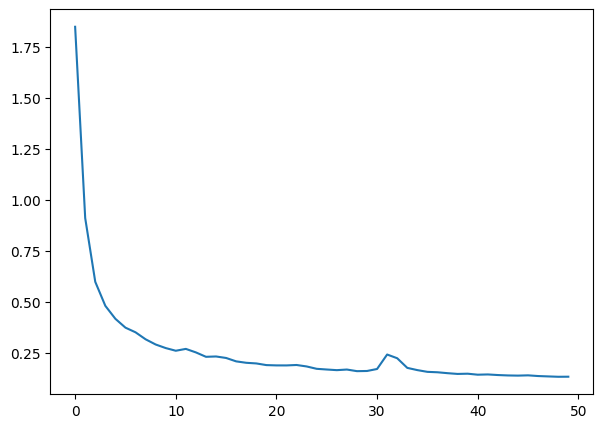

In [52]:
plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.show()

<a name='4-3'></a>
### 4.3 - mIoU

mIoU for test dataset images andaverage mIoU for all the images.

You can read about _mIoU_ metric and how it works [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/). Also, there are some other good resources on _Medium_, _Wikipedia_ and etc. on this subject. Just search for **What is mIoU in semantic segmentation**.


In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_miou(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    cm += confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

    iou = np.zeros(num_classes)
    for i in range(num_classes):
      true_positive = cm[i, i]
      false_positive = cm[:, i].sum() - true_positive
      false_negative = cm[i, :].sum() - true_positive

      sums = true_positive + false_positive + false_negative

      if sums == 0:
        iou[i] == np.nan
      else:
        iou[i] = true_positive / sums
    miou = np.nanmean(iou)
    return miou

In [54]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  images, masks = batch
  images = images.to(device)
  masks = masks.to(device)
  with torch.no_grad():
    model_prediction = unet(images)
    preds = create_mask(model_prediction)
    current_miou = calculate_miou(masks.cpu().numpy(), preds.cpu().numpy(), num_classes)
    mious.append(current_miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")

average miou for test dataset: 0.46505890605546546


<a name='4-3'></a>
### 4.5 - Show Predictions

Now, let's see your predictions (masks) vs ground truth masks to understand how well your model did.

In [55]:
def show_predictions(dataloader, device, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(test_dataloader):
        if i > num:
            break
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            model_predictions1 = unet(images)
            preds1 = create_mask(model_predictions1)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(images[0].cpu().permute(1, 2, 0))
        axes[0].set_title("Input Image")

        axes[1].imshow(masks[0].cpu())
        axes[1].set_title("True Mask")

        axes[2].imshow(preds1[0].cpu())
        axes[2].set_title("Predicted Mask")

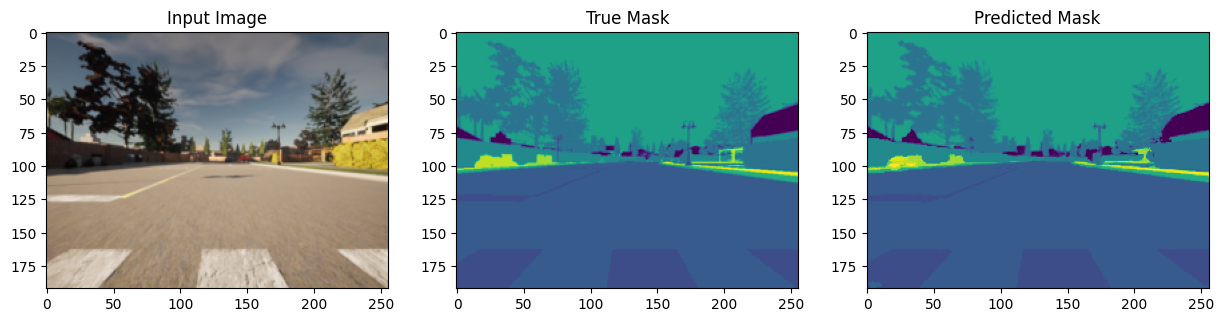

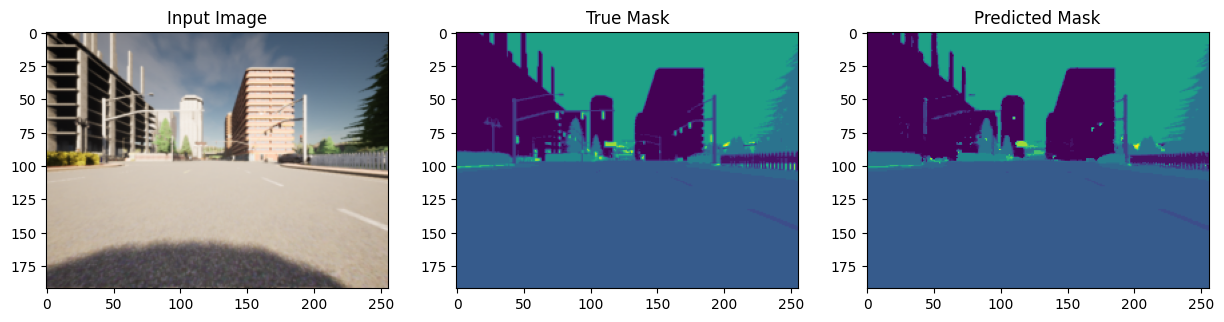

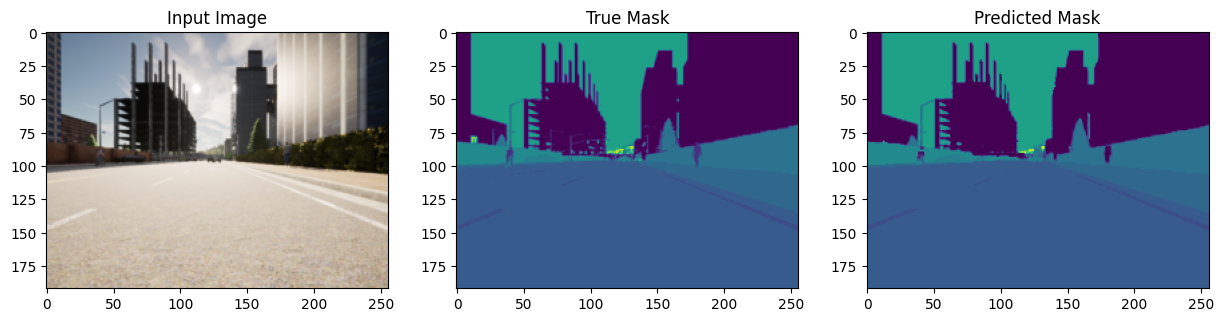

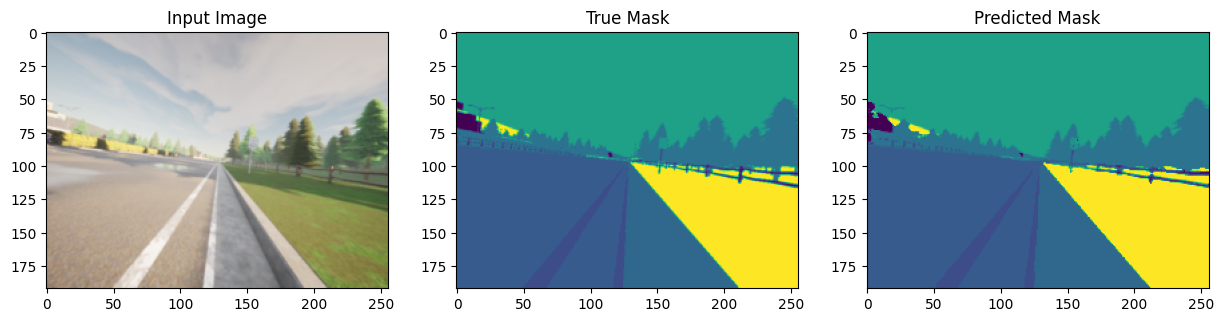

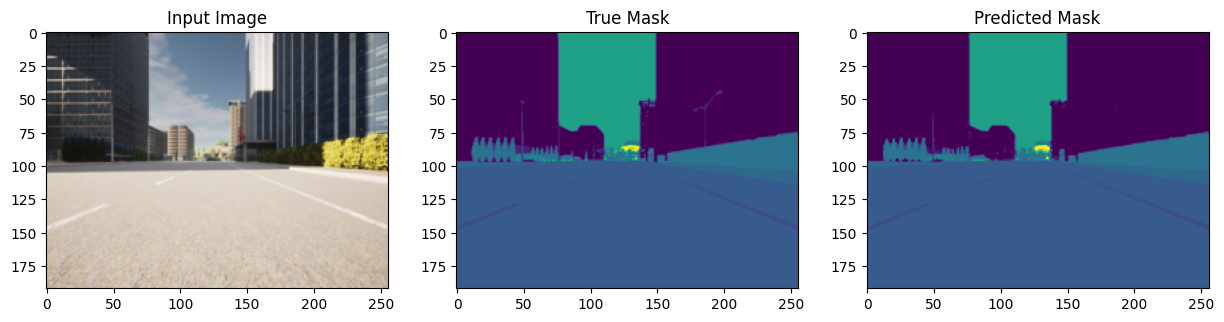

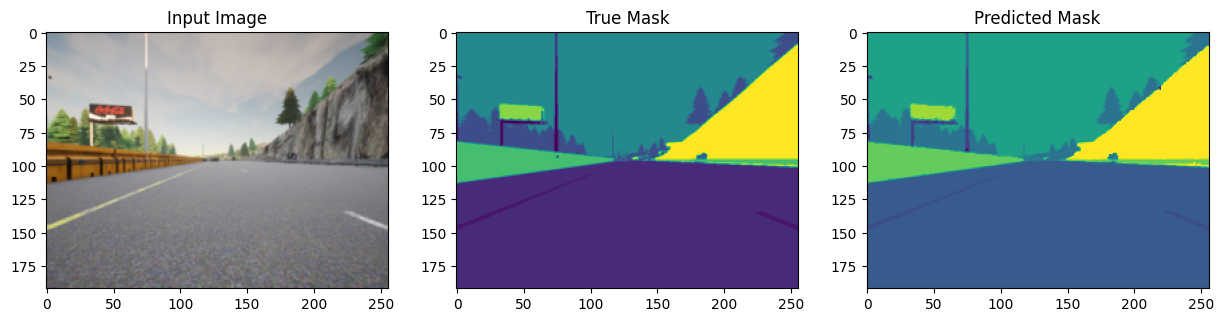

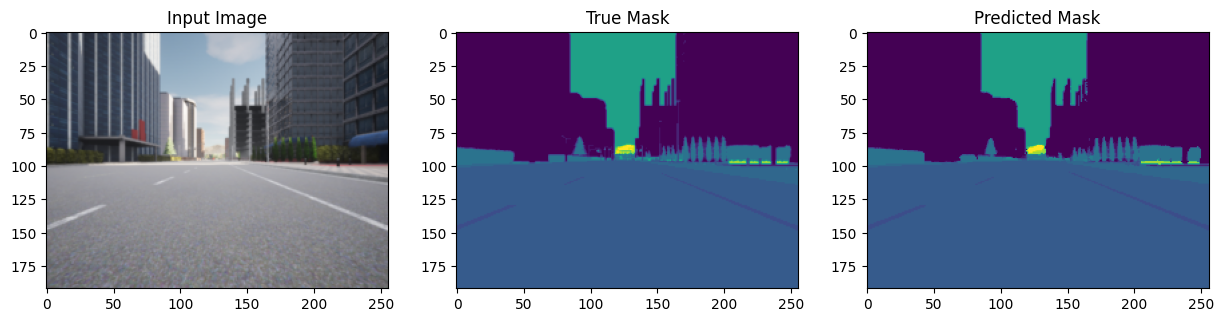

In [57]:
show_predictions(test_dataloader, device, 6)

## 5. Making the architecture better?!

Here, we want to try to make the UNet's model architecture, better. We try an approach named __Attention UNet__. This architecture tries to focus on the important parts of the image, and ignore the rest. Using this idea, we try to make the features (in `upsampling` steps) better, to finally reach a better __Decoder__ and thus, better predictions.

## 5.1 - Attention UNet

Here, is an overview of general architecture of Attention UNet:

<img src="./Images/1.png" style="width:100%;height:auto;">

As you can see, the architecture is similar to the UNet, but with the addition of Attention Gates. These gates are used to focus on the important parts of the image, and ignore the rest. But, what are these attention gates, precisely?!

<img src="./Images/2.png" style="width:100%;height:auto;">

As you can see, the attention gate is a simple architecture, which uses the features from the encoder, and the features from the decoder, adds them and also uses residual connections to output $\hat{x_l}$. Please note that $W_x \in \mathbb{R}^{F_l \times F_{int}}$, $W_g \in \mathbb{R}^{F_g \times F_{int}}$ and $\Psi \in \mathbb{R}^{F_{int} \times 1}$ are linear transformations which are being computed using channel-wise $1 \times 1 \times 1$ convolutions for the input tensors. In other contexts, this is called _vector concatenation-based attention_, where the concatenated features $x^l$ and $g$ are linearly mapped into a $\mathbb{R}^F_{int}$ dimensional _intermediate_ space.

Let's design the `AttentionBlock` class, which will be used in the `AttentionUNet` model:

In [58]:
class CompleteAttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(CompleteAttentionBlock, self).__init__()
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=3, stride = 2, padding = 1),
            nn.BatchNorm2d(F_int),
        )
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int),
        )
        
        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.upsample = nn.ConvTranspose2d(F_int, F_l, kernel_size=2, stride = 2)

    def forward(self, x, g):
                
        x_out = self.W_x(x)
        g_out = self.W_g(g)
        relu_out = self.relu(x_out + g_out)
        psi = self.psi(relu_out)
        sig_out = self.sigmoid(psi)
        resampled = self.upsample(sig_out)
        
        return x * resampled

In [59]:
class AttentionBlock(nn.Module):
    def __init__(self, F_l, F_int, F_g):
        super(AttentionBlock, self).__init__()
        
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.W_g = nn.ConvTranspose2d(F_g, F_int, kernel_size = 2, stride = 2)
        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Conv2d(F_int, F_int, kernel_size=1)

    def forward(self, x, g):
                
        x_out = self.W_x(x)
        g_out = self.W_g(g)
        relu_out = self.relu(x_out + g_out)
        psi = self.psi(relu_out)
        
        return x * psi

In [60]:
class UNet_With_Attention(nn.Module):
    def __init__(self, in_ch=3, n_filters = 32, n_classes = 23):
        """
        UNet with Attention

        Arguments:
            in_ch -- Number of channels of input tensor from previous layer
            out_channel -- Number of channels of output tensor
        """
        super().__init__()
        
        # Down-sampling
        self.encoder1 = conv_block(in_ch = in_ch, n_filters = n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder2 = conv_block(in_ch = n_filters, n_filters = 2 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder3 = conv_block(in_ch = 2 * n_filters, n_filters = 4 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder4 = conv_block(in_ch = 4 * n_filters, n_filters = 8 * n_filters, dropout_prob = 0, max_pooling=True)
        self.encoder5 = conv_block(in_ch = 8 * n_filters, n_filters = 16 * n_filters, dropout_prob = 0, max_pooling=False)
            
        # Up-sampling and final layer
        self.decoder4 = upsampling_block(in_ch = 16 * n_filters, skip_ch = 8 * n_filters, n_filters = 8 * n_filters)
        self.decoder3 = upsampling_block(in_ch = 8 * n_filters, skip_ch = 4 * n_filters, n_filters = 4 * n_filters)
        self.decoder2 = upsampling_block(in_ch = 4 * n_filters, skip_ch = 2 * n_filters, n_filters = 2 * n_filters)
        self.decoder1 = upsampling_block(in_ch = 2 * n_filters, skip_ch = n_filters, n_filters = n_filters)
        
        self.final_layer = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        
        # Attention Gates
        self.attention4 = AttentionBlock(F_l = 8 * n_filters, F_int = 8 * n_filters, F_g = 16 * n_filters)
        self.attention3 = AttentionBlock(F_l = 4 * n_filters, F_int = 4 * n_filters, F_g = 8 * n_filters)
        self.attention2 = AttentionBlock(F_l = 2 * n_filters, F_int = 2 * n_filters, F_g = 4 * n_filters)
        self.attention1 = AttentionBlock(F_l = n_filters, F_int = n_filters, F_g = 2 * n_filters)


    def forward(self, x):
        """
        UNet with Attention forward

        Arguments:
            x -- Input data/batch

        Returns:
            out -- Tensor output (Segmented image)
        """
        next_layer1, skip_connection1 = self.encoder1(x)
        next_layer2, skip_connection2 = self.encoder2(next_layer1)
        next_layer3, skip_connection3 = self.encoder3(next_layer2)
        next_layer4, skip_connection4 = self.encoder4(next_layer3)
        next_layer5, _ = self.encoder5(next_layer4)
        
        attention_out4 = self.attention4(skip_connection4, next_layer5)
        next_layer6 = self.decoder4(next_layer5, attention_out4)
            
        attention_out3 = self.attention3(skip_connection3, next_layer6)
        next_layer7 = self.decoder3(next_layer6, attention_out3)
        
        attention_out2 = self.attention2(skip_connection2, next_layer7)
        next_layer8 = self.decoder2(next_layer7, attention_out2)
        
        attention_out1 = self.attention1(skip_connection1, next_layer8)
        next_layer9 = self.decoder1(next_layer8, attention_out1)

        
        out = self.final_layer(next_layer9)

        return out

In [61]:
unet = UNet_With_Attention().to(device)

In [62]:
optimizer = optimizer=torch.optim.Adam(unet.parameters(), 
                           lr = LR, 
                           betas = (B1, B2))

criterion = nn.CrossEntropyLoss()

In [63]:
losses = []
for epoch in range(EPOCHS):
    epoch_losses = []

    for i, batch in enumerate(train_dataloader):
        image1, mask1 = batch
        image1 = image1.to(device)
        mask1 = mask1.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = unet(image1)  # Forward pass
                        
        loss = criterion(outputs, mask1.long())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        
        epoch_losses.append(loss.item())
    
    mean_loss = np.mean(epoch_losses)
    print(f"EPOCH#{epoch},\t Loss:{mean_loss}")
    losses.append(mean_loss)

EPOCH#0,	 Loss:1.5625958307734076
EPOCH#1,	 Loss:0.8003368895008879
EPOCH#2,	 Loss:0.6034784238293486
EPOCH#3,	 Loss:0.4981635420952203
EPOCH#4,	 Loss:0.4257896177048953
EPOCH#5,	 Loss:0.37710735145604835
EPOCH#6,	 Loss:0.3355217311742171
EPOCH#7,	 Loss:0.3172502157823095
EPOCH#8,	 Loss:0.305156613014779
EPOCH#9,	 Loss:0.27059677833656093
EPOCH#10,	 Loss:0.2518754879821022
EPOCH#11,	 Loss:0.2341259554871973
EPOCH#12,	 Loss:0.22144737249275423
EPOCH#13,	 Loss:0.2140510636118223
EPOCH#14,	 Loss:0.2244505893509343
EPOCH#15,	 Loss:0.2015725315179465
EPOCH#16,	 Loss:0.186770202978602
EPOCH#17,	 Loss:0.18016911480786665
EPOCH#18,	 Loss:0.17441594178946512
EPOCH#19,	 Loss:0.22714844064892464
EPOCH#20,	 Loss:0.20008329259899427
EPOCH#21,	 Loss:0.18421999351033624
EPOCH#22,	 Loss:0.24485236040826114
EPOCH#23,	 Loss:0.18311147729180893
EPOCH#24,	 Loss:0.17347056348368806
EPOCH#25,	 Loss:0.1623268171020274
EPOCH#26,	 Loss:0.15864449767571576
EPOCH#27,	 Loss:0.15491152343884954
EPOCH#28,	 Loss:0.1

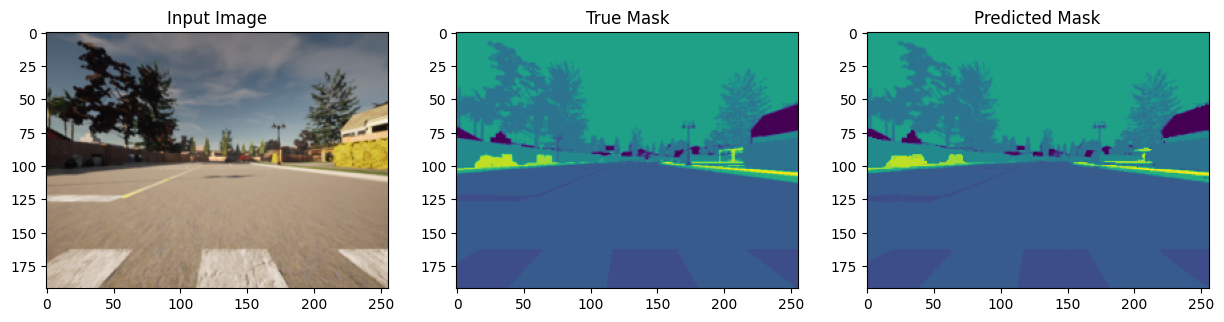

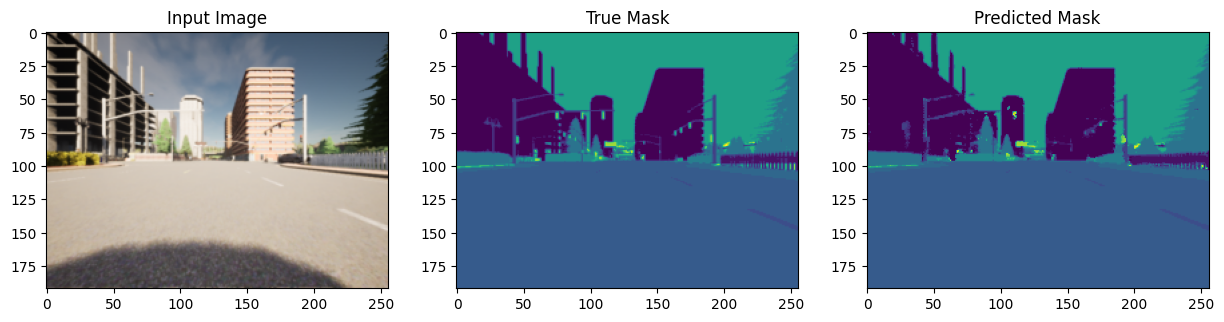

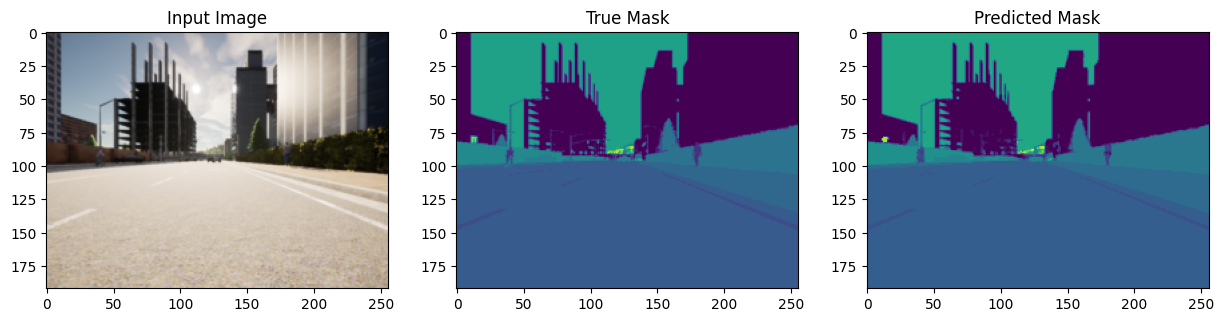

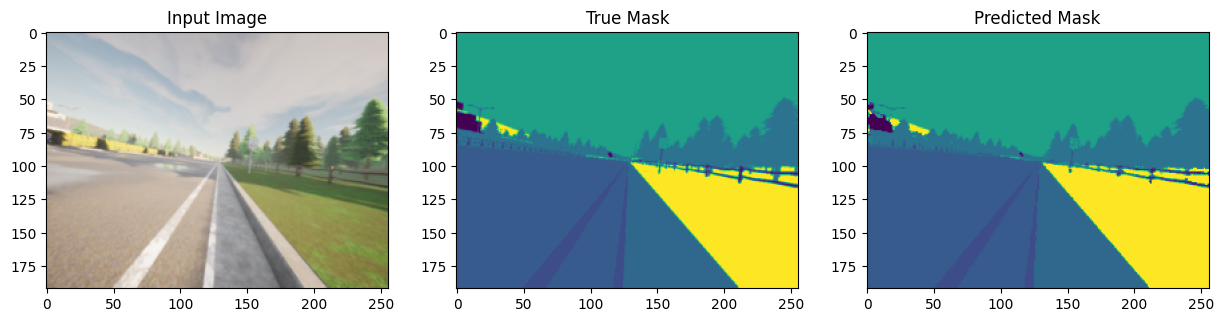

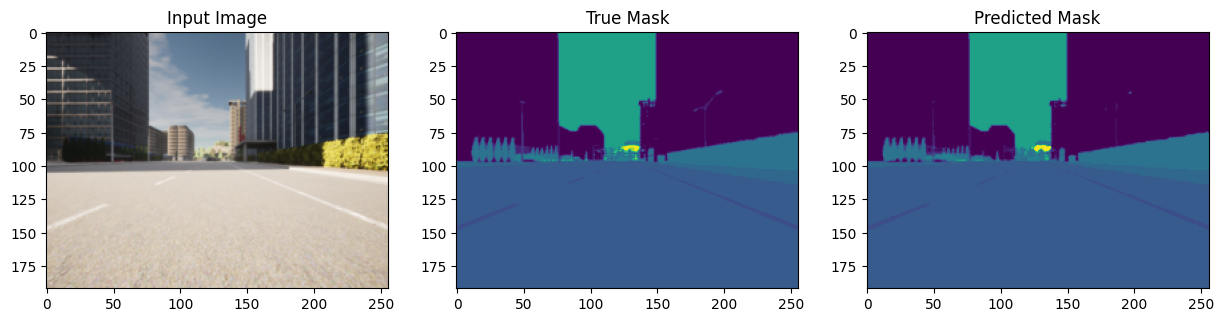

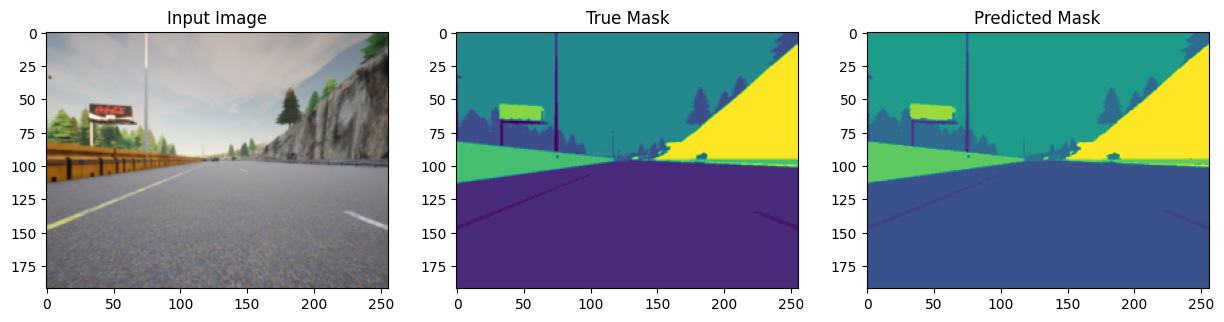

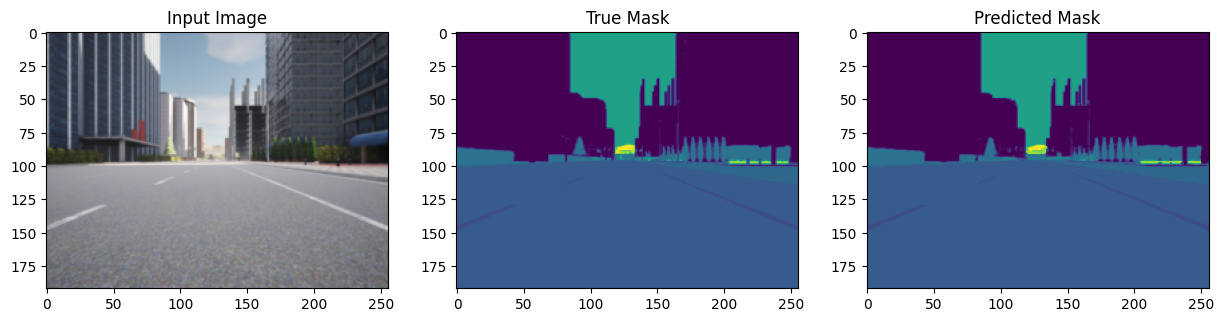

In [64]:
show_predictions(test_dataloader, device, 6)

Now, let's plot the `losses` vs `epochs` for the `AttentionUNet` model.

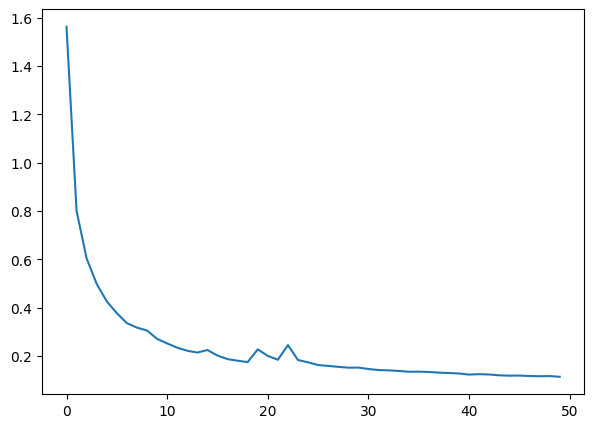

In [69]:
plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.show()

<a name='5-2'></a>
### 5.2 - mIoU

calculate mIoU for test dataset images with new model using the defined function above and report average mIoU for all the images.

In [70]:
num_classes = 23
mious = []
for i, batch in enumerate(test_dataloader):
  images, masks = batch
  images = images.to(device)
  masks = masks.to(device)
  with torch.no_grad():

    model_prediction = unet(images)
    preds = create_mask(model_prediction)
    current_miou = calculate_miou(masks.cpu().numpy(), preds.cpu().numpy(), num_classes)
    mious.append(current_miou)

print(f"average miou for test dataset: {sum(mious) / len(mious)}")

average miou for test dataset: 0.49932959970228147
